## Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from fastai.vision.all import *
from fastai.text.all import *
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

import torchtext
from torchtext.data import get_tokenizer   # for tokenization
from collections import Counter     # for tokenizer

import torchvision.transforms as T
import torchvision.models as models

import matplotlib.pyplot as plt
# import matplotlib.image as Image
import PIL
from PIL import Image

# for the bleu scores
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Preprocessing

In [3]:
captions_path = "./train.csv"
images_path = "./train/"

### Read the Captions

In [4]:
# READ THE CAPTIONS FILE.txt
df = pd.read_csv(captions_path)

print(f"No of captions: {len(df)}")
df.head()

No of captions: 74565


,img_name,img_path,mos,comments
0,41wy7upxzl,./train/41wy7upxzl.jpg,5.569231,"the pink and blue really compliment each other. like the dense color, blur."
1,ygujjq6xxt,./train/ygujjq6xxt.jpg,6.103175,love rhubarb! great colors!
2,wk321130q0,./train/wk321130q0.jpg,5.541985,i enjoy the textures and grungy feel to this. i also really like the deep rich red color.
3,w50dp2zjpg,./train/w50dp2zjpg.jpg,6.234848,"i like all the different colours in this pic, the brown, green, dark grey, light grey, cool image."
4,l7rqfxeuh0,./train/l7rqfxeuh0.jpg,5.190476,"i love these critters, just wish he was a little sharper, nice comp though."


### Descriptor mapping

In [5]:
class my_dictionary(dict): 
  
    # __init__ function 
    def __init__(self): 
        self = dict() 
          
    # Function to add key:value 
    def add(self, key, value): 
        if key not in self.keys():
            self[key] = [value]
        else:
            self[key].append(value)
        
descriptors = my_dictionary() 

In [6]:
for i in range(len(df)):
    img_id = df.iloc[i, 0] + ".jpg"
    sentence = ("<start> " + df.iloc[i, 3] + " <end>").split()
    
    descriptors.add(img_id, sentence)

In [7]:
print(descriptors['000u6xf6ah.jpg'])

[['<start>', 'colors', 'are', 'missing', 'the', 'natural', 'feeling', 'and', 'are', 'a', 'bit', 'flat', '<end>']]


### Check any Image

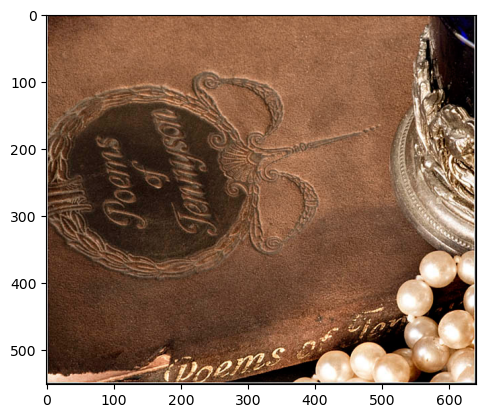

love the idea. the books texture is a bit flat though.


In [8]:
# get image path
image_indx = 20
image_path = images_path + df.iloc[image_indx, 0] + ".jpg"

# read the image
img = Image.open(image_path)
plt.imshow(img)
plt.show()

# print the captions related to this image
for i in range(image_indx, image_indx+1):
    print(df.iloc[i, 3])

## Data Processing

In [9]:
# TOKENIZER
tokenizer = get_tokenizer("basic_english")

# TOKEN COUNTER
token_counter = Counter()

### Text Data

In [10]:
class textVocab:
    # method to initialize the variables
    def __init__(self):
        # MAIN DICT
        # create dict (int to word) (like token counter)
        self.itos = {0:"<PAD>", 1:"<start>", 2:"<end>", 3:"<UNK>"}
        
        # create dict (word to int) 
        self.stoi = {b:a for a, b in self.itos.items()}   
        
        # initialize word freq threshold
        self.min_freq = 1
        
        # MAIN COMPONENTS
        # tokenizer
        self.tokenizer = get_tokenizer("basic_english")

        # token counter
        self.token_counter = Counter()
        
    # method to get size of vocabulary
    def __len__(self):
        return len(self.itos)
    
    # method to tokenize sentence
    def tokenize(self, text):
        return self.tokenizer(text)
    
    # method to numericalize sentence
    def numericalize(self, text):
        
        # tokenize the sentence
        tokens_list = self.tokenize(text)
        
        ans = []
        # convert words into ints (using stoi)
        for token in tokens_list:
            if token in self.stoi.keys():
                ans.append(self.stoi[token]) 
            else:
                ans.append(self.stoi["<UNK>"])
        return ans
#         return [ self.stoi[token] if token in self.stoi.keys() else self.stoi["<UNK>"] for token in tokens_list]
    
    # method to add new sentences to dict
    def build_vocab(self, sentence_list):
        word_count = 4
        
        # for each sentence
        for sentence in sentence_list:
            
            # tokenize
            tokens = self.tokenizer(sentence)
            
            # numericalize
            token_counter.update(tokens)
            
            # add words to vocab whose freq is >= min freq
            for token in tokens:
                if token_counter[token] >= self.min_freq and token not in self.stoi.keys():
                    self.stoi[token] = word_count
                    self.itos[word_count] = token
                    word_count += 1

### Image Data

In [11]:
inception = models.inception_v3(pretrained=True)

C:\Users\skghg\anaconda3\envs\daycon\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\skghg\anaconda3\envs\daycon\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
class MyInceptionFeatureExtractor(nn.Module):
    def __init__(self, inception, transform_input=False):
        super(MyInceptionFeatureExtractor, self).__init__()
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = inception.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = inception.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = inception.Conv2d_2b_3x3
        
        # extra layers has been added since the comment
        self.maxpool1 = inception.maxpool1
        self.Conv2d_3b_1x1 = inception.Conv2d_3b_1x1
        self.Conv2d_4a_3x3 = inception.Conv2d_4a_3x3
        self.maxpool2 = inception.maxpool2
        
        self.Mixed_5b = inception.Mixed_5b
        self.Mixed_5c = inception.Mixed_5c
        self.Mixed_5d = inception.Mixed_5d
        self.Mixed_6a = inception.Mixed_6a
        self.Mixed_6b = inception.Mixed_6b
        self.Mixed_6c = inception.Mixed_6c
        self.Mixed_6d = inception.Mixed_6d
        self.Mixed_6e = inception.Mixed_6e
        
        self.AuxLogits = inception.AuxLogits
        
        self.Mixed_7a = inception.Mixed_7a
        self.Mixed_7b = inception.Mixed_7b
        self.Mixed_7c = inception.Mixed_7c
        
        # stop where you want, copy paste from the model def

    def forward(self, x):
        
        # 299 x 299 x 3
        x = self.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        x = self.maxpool1(x)
        # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x)
        # 71 x 71 x 192
        x = self.maxpool2(x)
        # 35 x 35 x 192
        x = self.Mixed_5b(x)
        # 17 x 17 x 768
        x = self.Mixed_5c(x)
        # 17 x 17 x 768
        x = self.Mixed_5d(x)
        # 17 x 17 x 768
        x = self.Mixed_6a(x)
        # 17 x 17 x 768
        x = self.Mixed_6b(x)
        # 17 x 17 x 768
        x = self.Mixed_6c(x)
        # 17 x 17 x 768
        x = self.Mixed_6d(x)
        # 17 x 17 x 768
        x = self.Mixed_6e(x)
        # 17 x 17 x 768
        x = self.Mixed_7a(x)
        # 8 x 8 x 1280
        x = self.Mixed_7b(x)
        # 8 x 8 x 2048
        x = self.Mixed_7c(x)
        
        return x

In [13]:
# define the transforms
inception_Transform = T.Compose([
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Datasets and DataLoaders

### Custom Datasets

In [14]:
class customDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None, min_freq=5):
        self.image_dir = image_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        
        # get image ids and captions 
        self.img_ids = self.df["img_name"]
        self.sentences = self.df["comments"]
        
        # initialize vocabulary
        self.vocab = textVocab()
        
        # create vocabulary (using list of sentences)
        self.vocab.build_vocab(self.sentences.tolist())
        
    def __len__(self):
        return len(self.df)
    
    # method to return pair of input and output data
    def __getitem__(self, idx):
        
        # get the caption and image path
        sentence = self.sentences[idx]
        img_id = self.img_ids[idx] + '.jpg'
        img_path = os.path.join(self.image_dir, img_id)
        
        # open the image
        img = Image.open(img_path).convert("RGB")
        
        # apply transformation on image(resize)
        if self.transform is not None:
            img = self.transform(img)
            
        # numericalize the caption
        vec = []
        
        vec += [self.vocab.stoi["<start>"]]   # tagging
        vec += self.vocab.numericalize(sentence)  # numericalization
        vec += [self.vocab.stoi["<end>"]]     # tagging
        
        # return text vector and image tensor
#         return img_id, vec
        return img, torch.tensor(vec), img_id

In [15]:
transforms = inception_Transform

In [16]:
transforms

Compose(
    Resize(size=299, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(299, 299))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [17]:
# Create custom dataset object
dataset = customDataset(
    image_dir = images_path,
    captions_file = captions_path,
    transform = transforms
)

In [18]:
with open('vocab.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(dataset.vocab, file)

### Divide dataset indices into 2 parts

In [19]:
validation_split = .8
test_split = .9
shuffle_dataset = False
random_seed= 42

In [20]:
dataset_size = len(dataset)
indices = list(range(dataset_size))

# find the split point
val_split = int(np.floor(validation_split * dataset_size))
test_split = int(np.floor(test_split * dataset_size))
    
# get the indices
train_indices, val_indices, test_indices = indices[:val_split], indices[val_split:test_split], indices[test_split:]

# shuffle the dataset
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    np.random.shuffle(test_indices)

### Check our dataset

In [21]:
# create utility function to print images
def show_image(img, title=None):
    
    # unnormalize
    img[0] *= 0.229
    img[1] *= 0.224
    img[2] *= 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)    # wait for plots

03hgnq4mgk.jpg


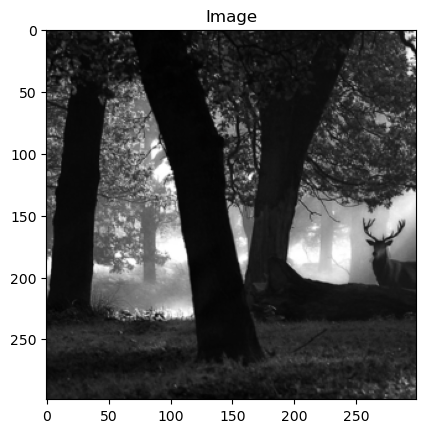

caption:  ['<start>', 'nice', 'capture', '.', 'the', 'light', 'quality', 'is', 'very', 'nice', '.', '<end>']


In [22]:
# get an item from dataset
img, vec, img_id = dataset[8083]
print(img_id)
show_image(img, "Image")

# need to convert returned vector into sentence
caption = [dataset.vocab.itos[token] for token in vec.tolist()]
print("caption: ", caption)

DataLoaders

Padding function

In [23]:
class Collate_fn:
    def __init__(self, pad_value, batch_first=False):
        self.pad_value = pad_value       # initialize padding value
        self.batch_first = batch_first    # col or row wise representation
        
    # this method is called for each batch in dataloader
    def __call__(self, batch):
        # get all inputs images
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)    # single tensor
        
        # get all captions
        captions = [item[1] for item in batch]
        
        # do padding on all text vectors   # single tensor
        captions = pad_sequence(captions, batch_first = self.batch_first, padding_value = self.pad_value)
        
        # get all image ids
        img_ids = [item[2] for item in batch]
        
        return imgs, captions, img_ids

### Create Dataloader

In [24]:
# define batch size
batch_size = 10

# initialize value to represent padding
pad_value = dataset.vocab.stoi["<PAD>"]

In [25]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [26]:
train_loader = torch.utils.data.DataLoader(dataset, 
                                           batch_size=batch_size, shuffle=False,
                                           collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, shuffle=False,
                                                batch_size=batch_size,
                                                collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                                sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(dataset, shuffle=False,
                                                batch_size=batch_size,
                                                collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                                sampler=test_sampler)

### Check Dataloader

i enjoy the contrast , black and white is an excellent choice .


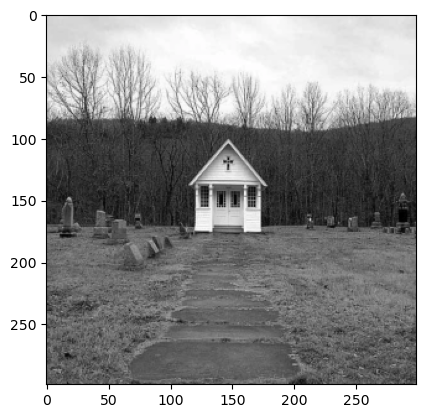

In [27]:
# dataloader iterator
trainItr = iter(train_loader)

# get a batch
batch = next(trainItr)

# get input and output values
imgs, captions, img_ids = batch

# show all items in it
for i in range(batch_size):
    img, caption = imgs[i], captions[i]
    
    # convert text vector into sentence
    sentence = [dataset.vocab.itos[token] for token in caption.tolist()]
    
    # get index of end token
    end_indx = sentence.index('<end>')
    
    # get from start to end and join
    sentence = sentence[1:end_indx]
    sentence = ' '.join(sentence)
    
    # also print image
    print(sentence)
    show_image(img)
    plt.show()
    
    break

## Model Implementaion

### Encoder Model

In [28]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.my_inception = MyInceptionFeatureExtractor(inception)
        
    def forward(self, images):
#         print(images.shape) = [bs, 3, 299, 299]
        
        # get the feature maps
        features = self.my_inception(images) 
#         print(features.shape) = [bs, 2048, 8, 8]
        
        features = features.permute(0, 2, 3, 1)
#         print(features.shape) = [bs, 8, 8, 2048]
        
        features = features.view(features.size(0), -1, features.size(-1))
#         print(features.shape) = [2, 64, 2048]
        
        return features

### Attention Model

In [29]:
class Attention(nn.Module):
    
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        
        # initialize the shapes
        self.attention_dim = attention_dim
        
        # create linear layer's to transform following
        # (input shape, output shape)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # decoder's output
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # encoded image
        self.full_att = nn.Linear(attention_dim, 1)  # attention's output
    
    # input - features of image and hidden state value
    def forward(self, features, hidden_states):
        # pass the tensor's through linear layers
        att1 = self.encoder_att(features)   
        att2 = self.decoder_att(hidden_states)
        
#         print(att1.shape, att2.shape)   # torch.Size([32, 64, att_dim]) torch.Size([32, att_dim])
        
        # combine both attentions
        combined_states = torch.tanh(att1 + att2.unsqueeze(1))
        
#         print(combined_states.shape)      # torch.Size([32, 64, att_dim])

        # pass combined state through last linear layer
        attention_scores = self.full_att(combined_states)
        
#         print(attention_scores.shape)     # torch.Size([bs, 64, 1])
        attention_scores = attention_scores.squeeze(2)
#         print(attention_scores.shape)   # torch.Size([32, 64])
        

        # calculate alpha 
        alpha = F.softmax(attention_scores, dim=1)
        
        # get attention weights
        weighted_encoding = features * alpha.unsqueeze(2)   # torch.Size([bs, 64, 1])
        weighted_encoding = weighted_encoding.sum(dim=1)    # sum all weights at dim 1
        
        # return alpha and attention weights (both are tensors)
        return alpha, weighted_encoding

### Decoder Model

In [30]:
class Decoder(nn.Module):
    def __init__(self, embed_sz, vocab_sz, att_dim, enc_dim, dec_dim, drop_prob=0.3):
        super().__init__()
        
        # initialize the model parameters
        self.vocab_sz = vocab_sz
        self.att_dim = att_dim
        self.dec_dim = dec_dim
        
        # initialize embedding model and attention model
        self.embedding = nn.Embedding(vocab_sz, embed_sz)
        self.attention = Attention(enc_dim, dec_dim, att_dim)
        
        # create the hidden and cell state
        self.init_h = nn.Linear(enc_dim, dec_dim)
        self.init_c = nn.Linear(enc_dim, dec_dim)
        
        # create lstm cell
        self.lstm_cell = nn.LSTMCell(embed_sz + enc_dim, dec_dim, bias=True)
        
        # create other nn layers
        self.f_beta = nn.Linear(dec_dim, enc_dim)
        self.fcn = nn.Linear(dec_dim, vocab_sz)
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self, features, captions):
        
        # vectorize the captions(tokenized):
        embeds = self.embedding(captions)
        
        # initialize hidden and cell state
        h, c = self.init_hidden_state(features)
        
        # get the captions length in current batch
        cap_len = len(captions[0]) - 1
        
        # get batch size and features size
        batch_sz = captions.size(0)
        num_features = features.size(1)
        
        # create tensor of zeros for predictions and alpha
        preds = torch.zeros(batch_sz, cap_len, self.vocab_sz).to(device)
        alphas = torch.zeros(batch_sz, cap_len, num_features).to(device)
        
        for i in range(cap_len):
            # get alpha and attention weights
            alpha, att_weights = self.attention(features, h)
            
            # create lstm input
            lstm_input = torch.cat((embeds[:,i], att_weights), dim=1)
            
            # pass through lstm cell
            h, c = self.lstm_cell(lstm_input, (h, c))
            
            # pass through linear layer
            output = self.fcn(self.drop(h))
            
            # store the output and alpha
            preds[:, i] = output
            alphas[:, i] = alpha
            
        return preds, alphas
    
    # create method to generate captions
    def generate_caption(self, features, max_len=20, vocab=None):
        batch_sz = features.size(0)
        
        # hidden and cell state
        h, c = self.init_hidden_state(features)
        
        alphas = []
        captions = [vocab.stoi['<start>']]
        
        # starting input
        word = torch.tensor(vocab.stoi['<start>']).view(1, -1).to(device)
        embeds = self.embedding(word)
        
        # get next 20 words
        for i in range(max_len):
            alpha, weighted_encoding = self.attention(features, h)
            
            # store alpha score
            alphas.append(alpha.cpu().detach().numpy())
            
            # update hidden and cell state
            lstm_input = torch.cat((embeds[:, 0], weighted_encoding), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            
            # pass through layers
            output = self.fcn(self.drop(h))
            output = output.view(batch_sz, -1)
            
            # select the best word
            pred_word_idx = output.argmax(dim=1)
            
            # save the word
            captions.append(pred_word_idx.item())
        
            # stop when end of sentence
            if vocab.itos[pred_word_idx.item()] == '<end>':
                break
                
            # next input
            embeds = self.embedding(pred_word_idx.unsqueeze(0))
            
        # return sentence
        return [vocab.itos[idx] for idx in captions], alphas  # if idx != 0 and idx != 1 and idx != 2
    
    # method to get hidden and cell state value
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        
        # return hidden and cell state
        return h, c

### Encoder-Decoder Model

In [31]:
class EncoderDecoder(nn.Module):
    def __init__(self, embed_sz, vocab_sz, att_dim, enc_dim, dec_dim, drop_prob=0.3):
        super().__init__()
        
        # crete the encoder and decoder models
        self.encoder = Encoder()
        self.decoder = Decoder(
            embed_sz = embed_sz,
            vocab_sz = vocab_sz,
            att_dim = att_dim,
            enc_dim = enc_dim,
            dec_dim = dec_dim
        )
    
    def forward(self, images, captions):
        # extract image features
        features = self.encoder(images)
        
        # generate captions
        outputs = self.decoder(features, captions)
        
        # return predicted caption, attention alphas
        return outputs

## Hyperparameters

In [32]:
embed_sz = 300
vocab_sz = len(dataset.vocab)
att_dim = 256
enc_dim = 2048
dec_dim = 512
learning_rate = 0.001

## Model

In [33]:
# initialize model
model = EncoderDecoder(
    embed_sz = 300,
    vocab_sz = len(dataset.vocab),
    att_dim = 128,
    enc_dim = 2048,
    dec_dim = 256
).to(device)

In [34]:
# create criterion and optimizer for weights
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [36]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [37]:
print_each = 100
epochs = 50

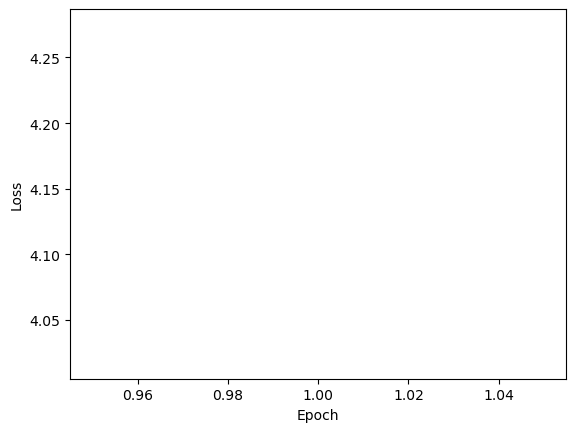

1 epochs : train_loss = 4.274042600486421, validation loss = 4.018164616030173


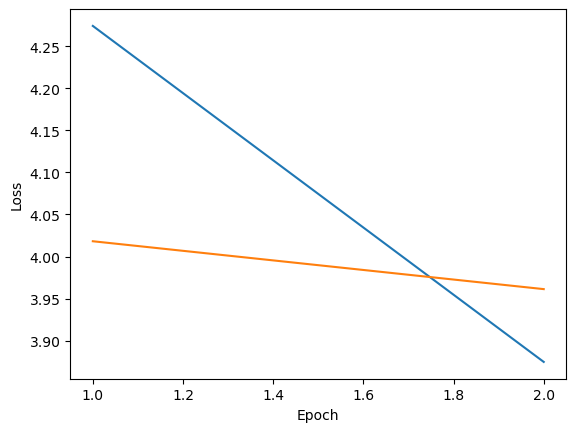

2 epochs : train_loss = 3.87476115941218, validation loss = 3.9612729738710266


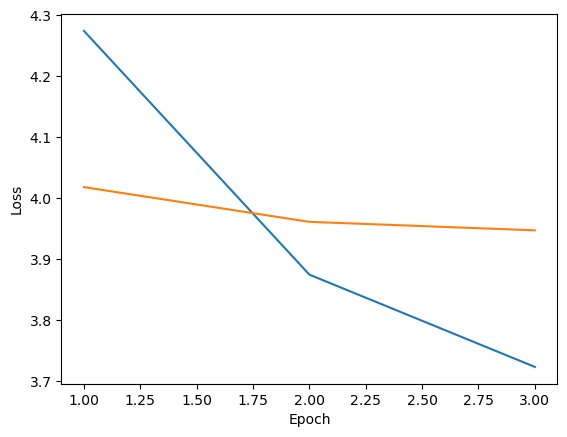

3 epochs : train_loss = 3.7235934284062226, validation loss = 3.9473701959132126


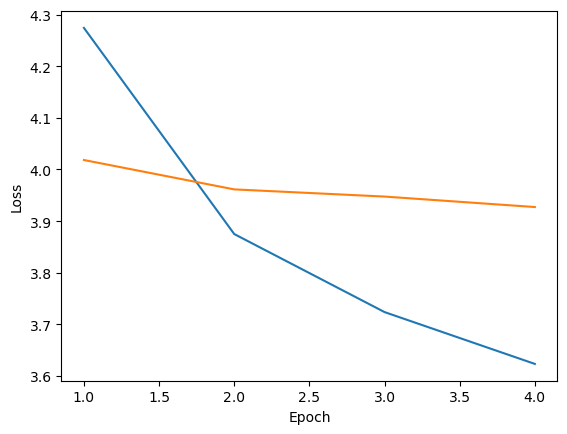

4 epochs : train_loss = 3.623199621484624, validation loss = 3.9270917508479353


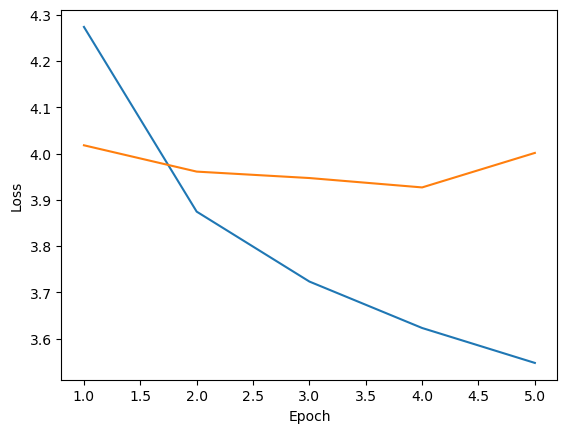

5 epochs : train_loss = 3.5477003867834185, validation loss = 4.001671091489526


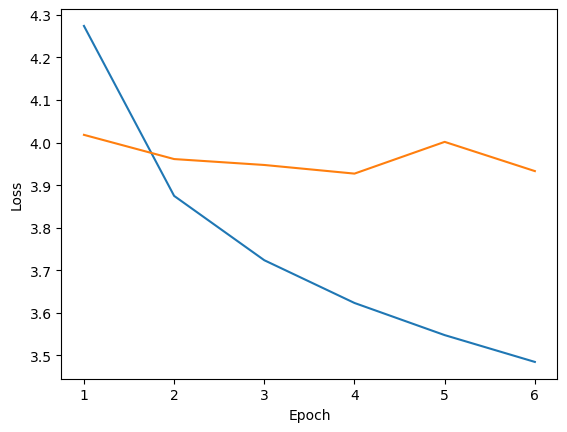

6 epochs : train_loss = 3.484720223100102, validation loss = 3.9330120909111694


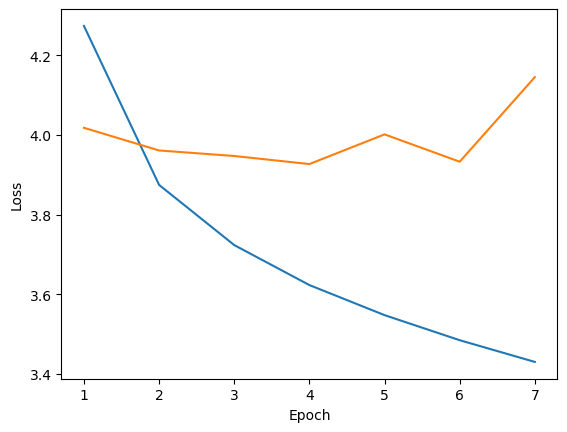

7 epochs : train_loss = 3.4301927639174603, validation loss = 4.14544538878576


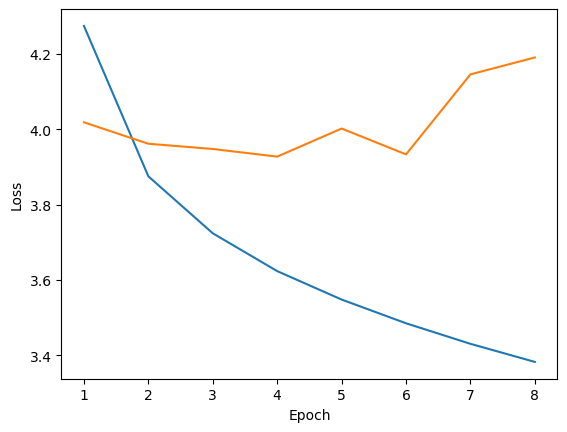

8 epochs : train_loss = 3.3821438876130743, validation loss = 4.19029641752591


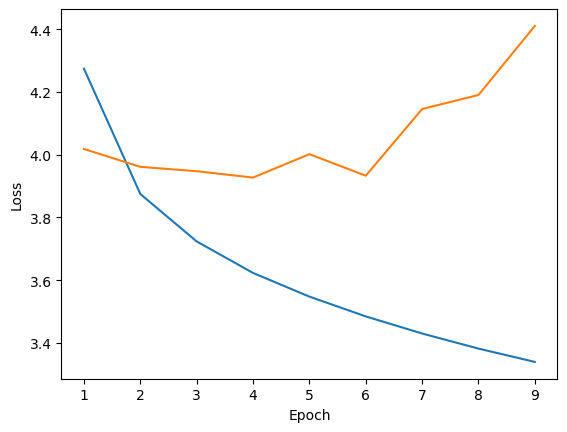

9 epochs : train_loss = 3.3396555226245477, validation loss = 4.410309842407959


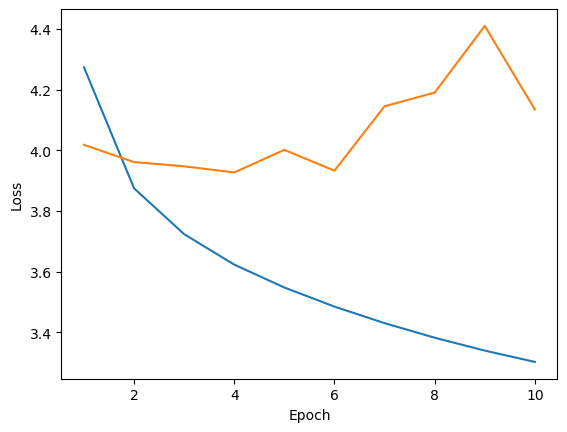

10 epochs : train_loss = 3.302299504243959, validation loss = 4.134735830863658


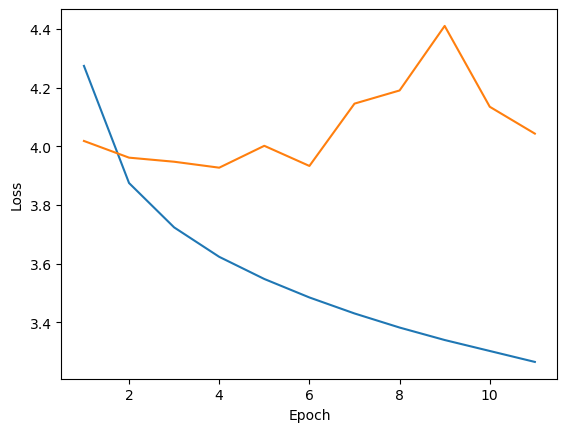

11 epochs : train_loss = 3.264980800257501, validation loss = 4.043174048350092


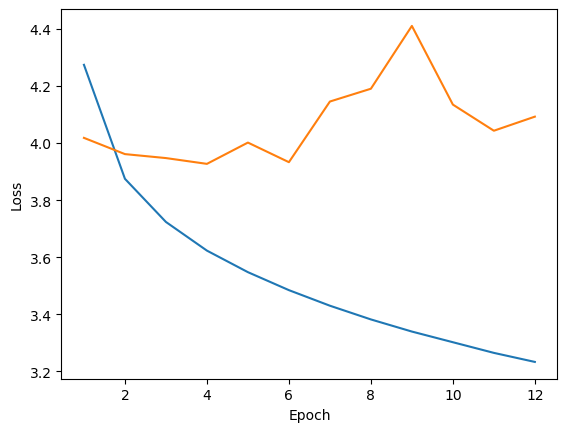

12 epochs : train_loss = 3.233292259529212, validation loss = 4.09245694303973


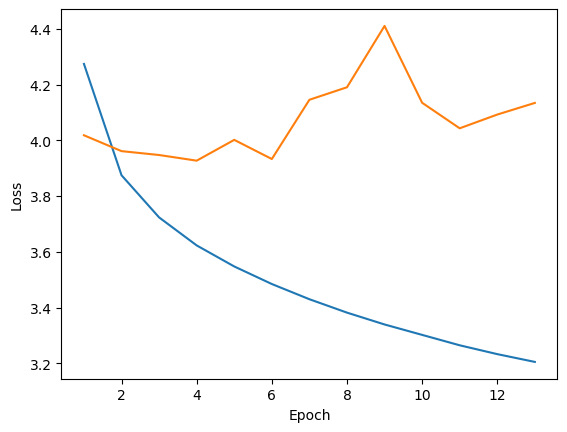

13 epochs : train_loss = 3.205349930357679, validation loss = 4.134202488885928


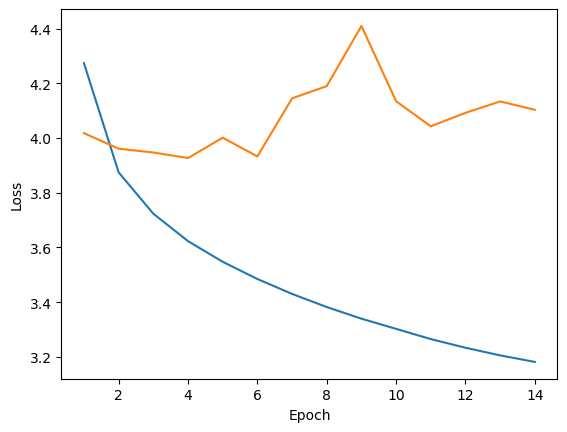

14 epochs : train_loss = 3.1814507400774503, validation loss = 4.1035791998129545


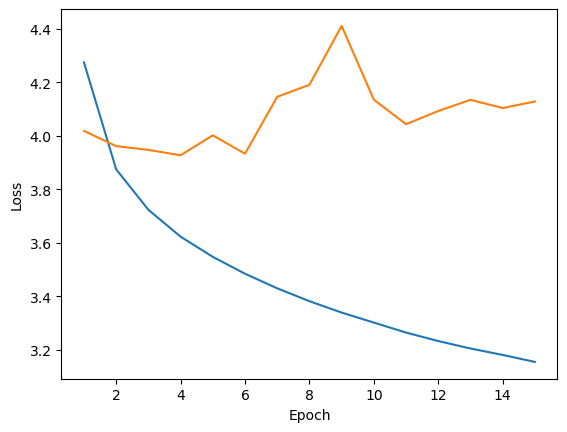

15 epochs : train_loss = 3.1552606624416413, validation loss = 4.128005956439501


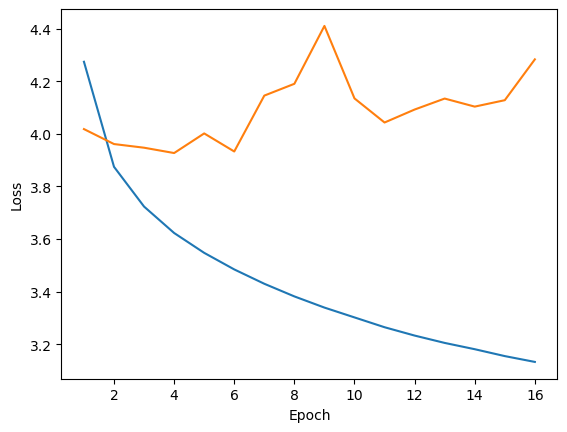

16 epochs : train_loss = 3.133117054291017, validation loss = 4.283195318646185


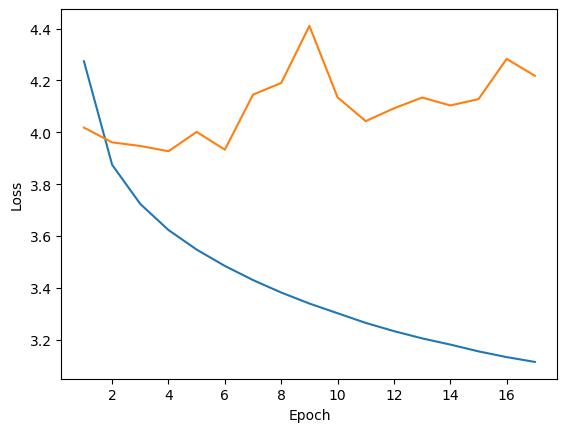

17 epochs : train_loss = 3.114541618067646, validation loss = 4.218088305303467


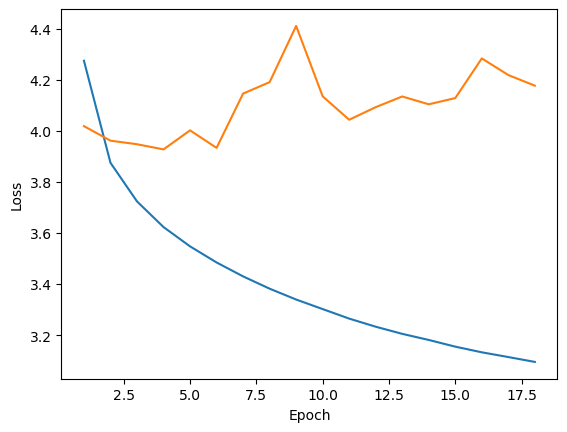

18 epochs : train_loss = 3.095508434639317, validation loss = 4.176478040576493


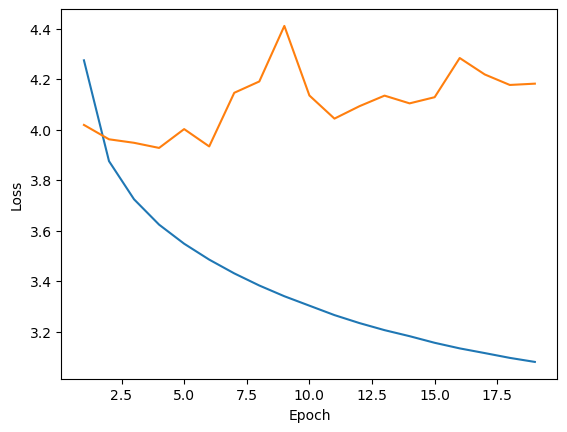

19 epochs : train_loss = 3.0795077345368527, validation loss = 4.181626343803856


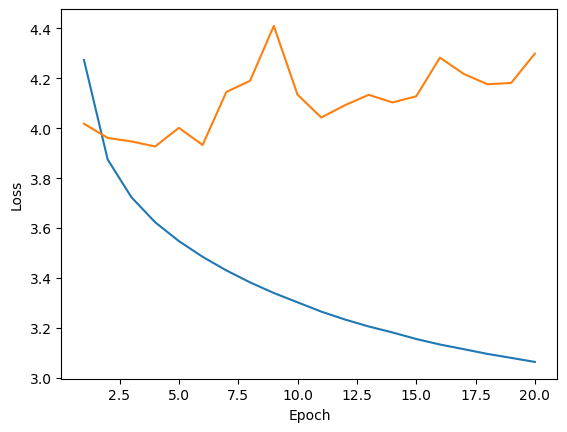

20 epochs : train_loss = 3.063317279752364, validation loss = 4.299128148305058


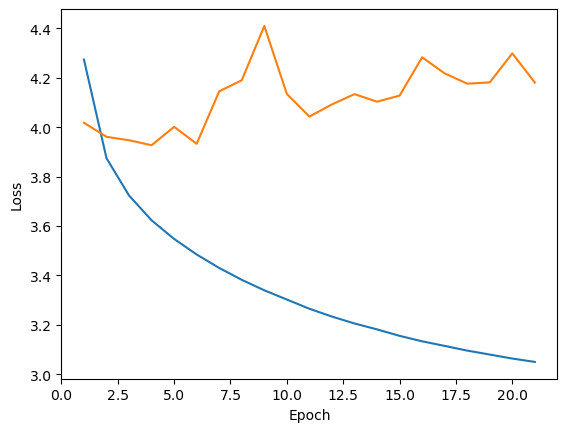

21 epochs : train_loss = 3.049666504860564, validation loss = 4.18084262042854


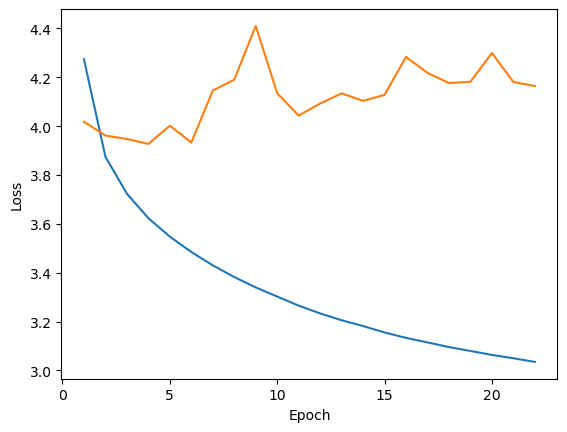

22 epochs : train_loss = 3.0346538070812876, validation loss = 4.164195069363701


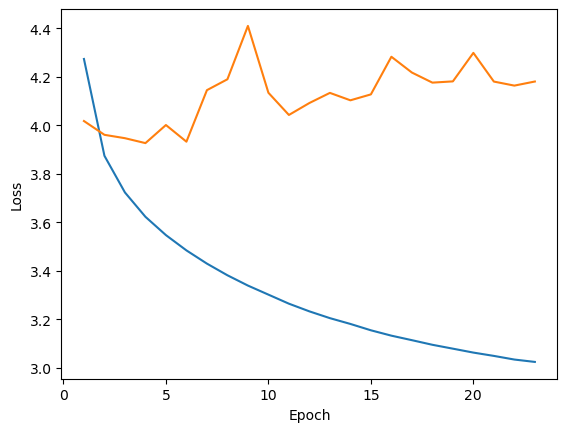

23 epochs : train_loss = 3.024847467708402, validation loss = 4.181077164066196


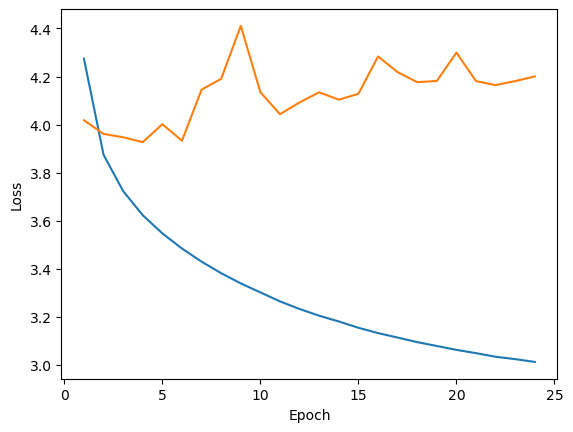

24 epochs : train_loss = 3.0132567235451946, validation loss = 4.20027346410209


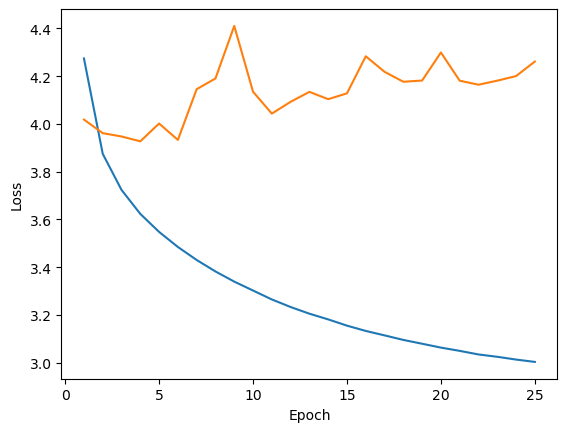

25 epochs : train_loss = 3.0033879714784972, validation loss = 4.261126742726232


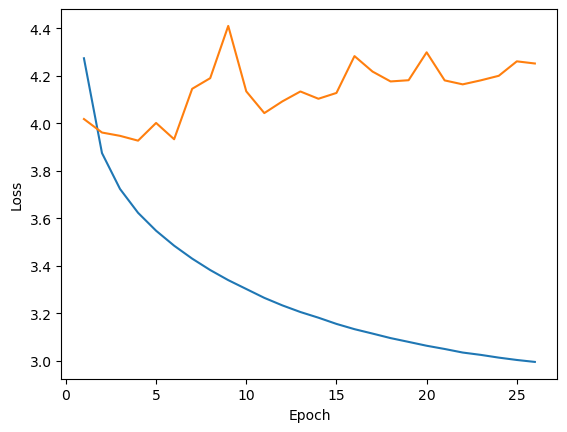

26 epochs : train_loss = 2.995162279379006, validation loss = 4.252064867592677


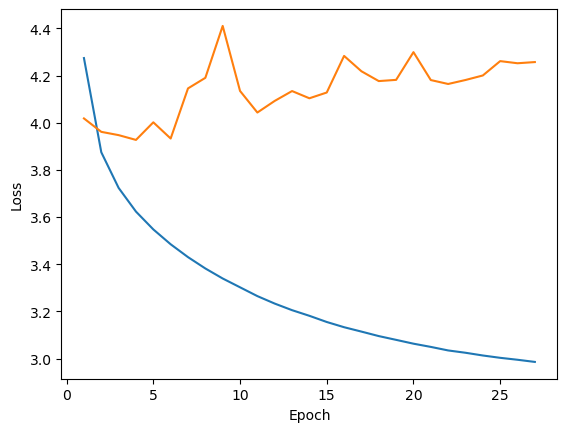

27 epochs : train_loss = 2.985992770011793, validation loss = 4.257083186328155


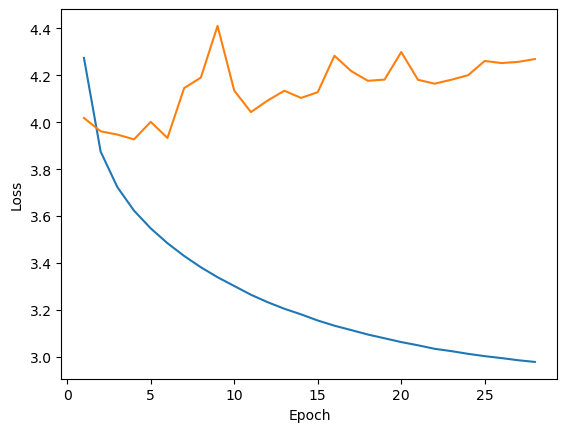

28 epochs : train_loss = 2.9787987516190633, validation loss = 4.269128087188553


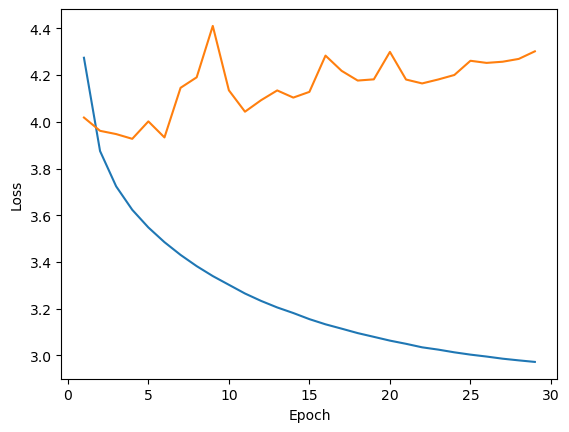

29 epochs : train_loss = 2.9721593001491065, validation loss = 4.301565378712482


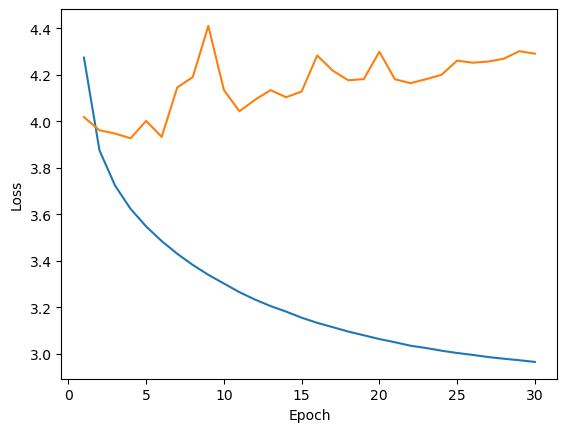

30 epochs : train_loss = 2.964962748409093, validation loss = 4.2907613304807395


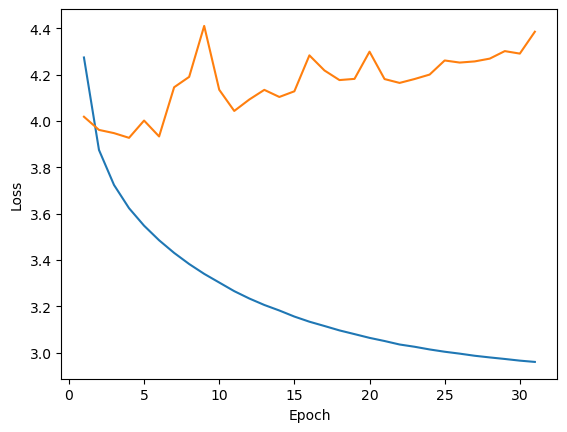

31 epochs : train_loss = 2.9594045316302497, validation loss = 4.38527122107954


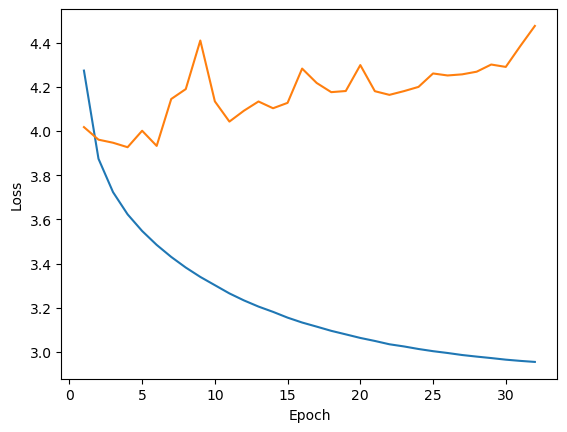

32 epochs : train_loss = 2.9547057715426632, validation loss = 4.4764293714270575


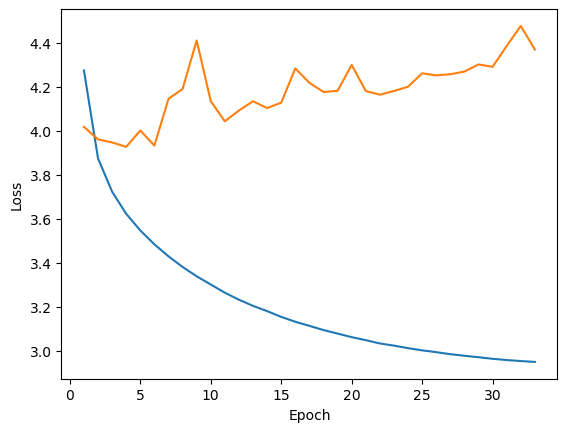

33 epochs : train_loss = 2.950819868089559, validation loss = 4.369303079186079


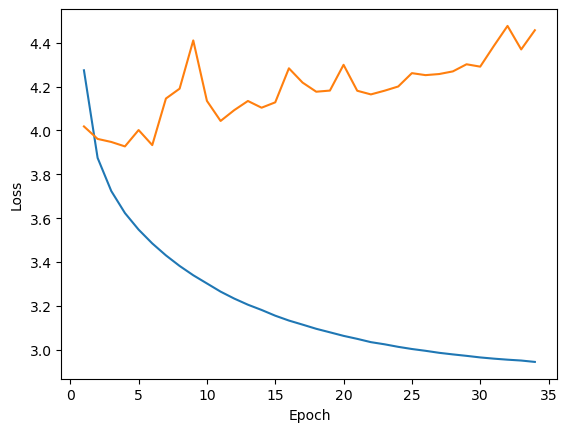

34 epochs : train_loss = 2.9444936633885432, validation loss = 4.456752945105405


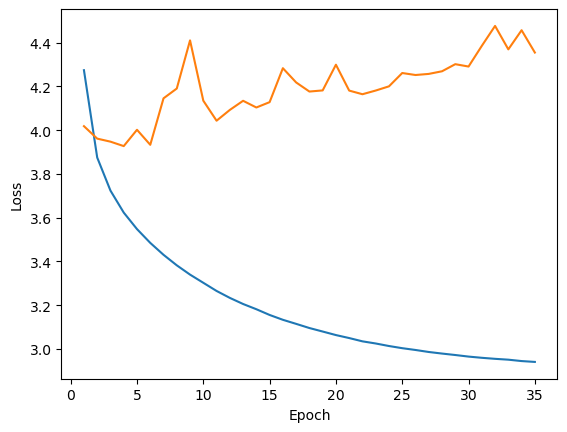

35 epochs : train_loss = 2.9405811375666135, validation loss = 4.35472324138803


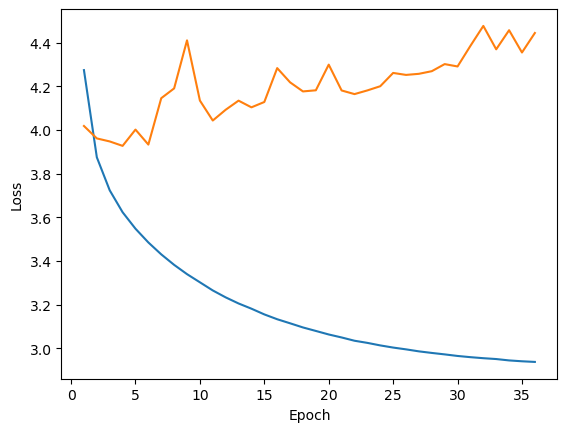

36 epochs : train_loss = 2.937638002134845, validation loss = 4.444068336115886


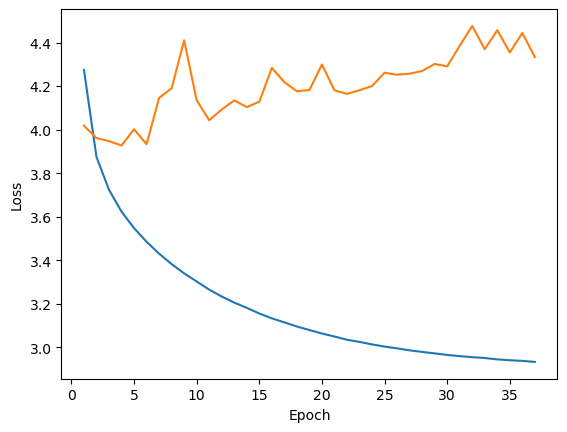

37 epochs : train_loss = 2.9328557589736284, validation loss = 4.333012485836709


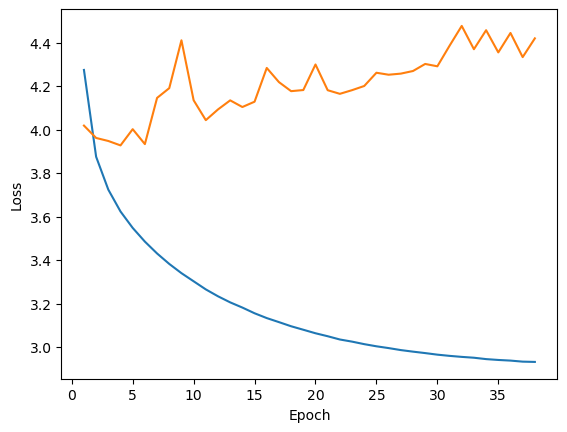

38 epochs : train_loss = 2.9315481778722106, validation loss = 4.419247185403697


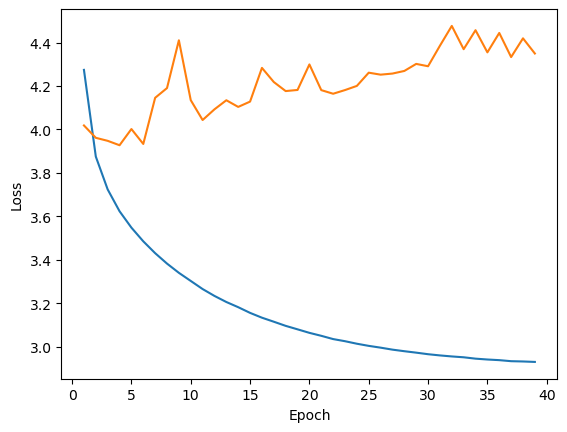

39 epochs : train_loss = 2.929470168727269, validation loss = 4.349470801427641


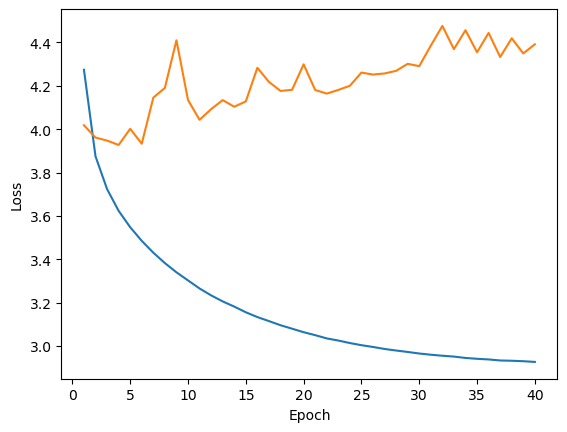

40 epochs : train_loss = 2.926177421917836, validation loss = 4.391613877318448


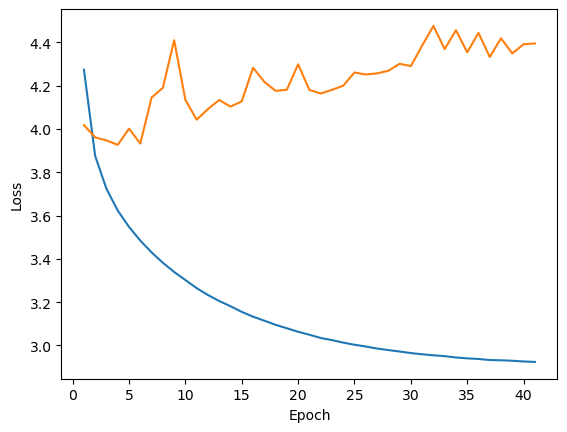

41 epochs : train_loss = 2.924057443497015, validation loss = 4.395566962563429


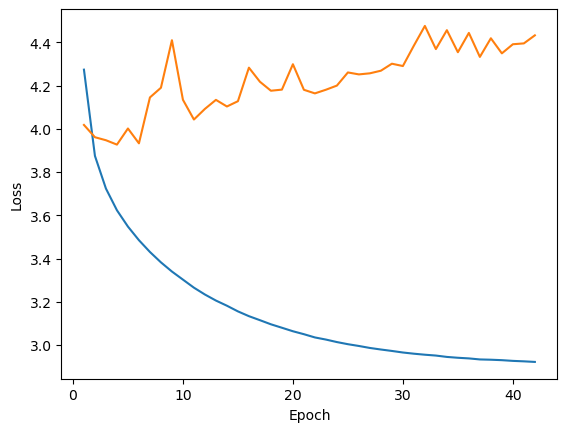

42 epochs : train_loss = 2.9213578451177784, validation loss = 4.432839924557526


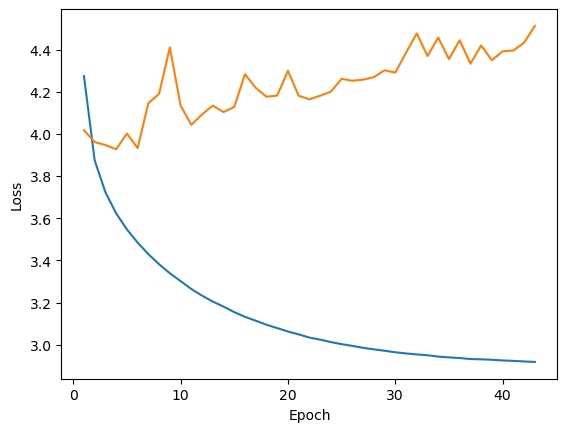

43 epochs : train_loss = 2.9191982756715853, validation loss = 4.511976597966554


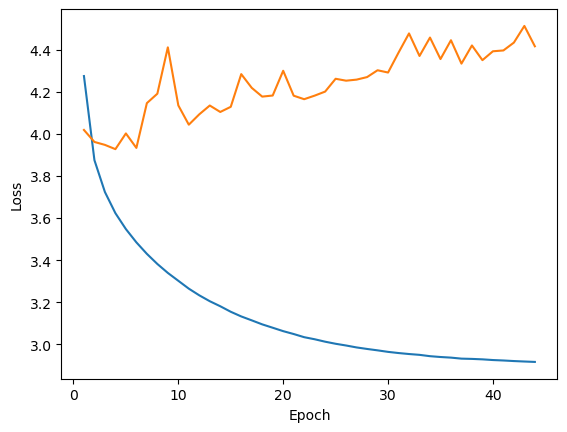

44 epochs : train_loss = 2.917247913332682, validation loss = 4.41530735451776


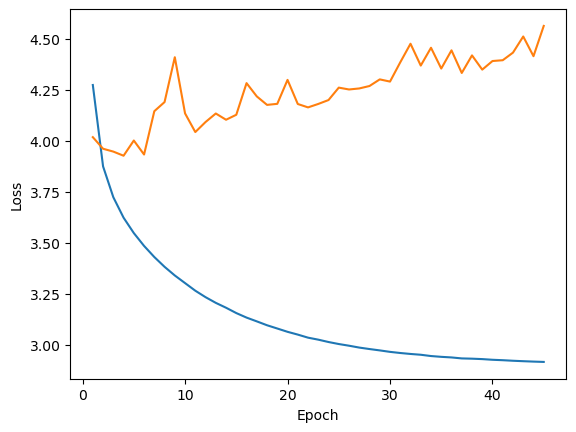

45 epochs : train_loss = 2.9156408690714, validation loss = 4.563812333370994


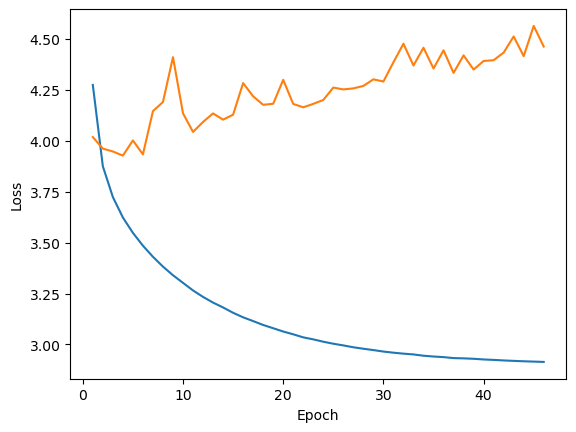

46 epochs : train_loss = 2.9140676344487377, validation loss = 4.462545540967213


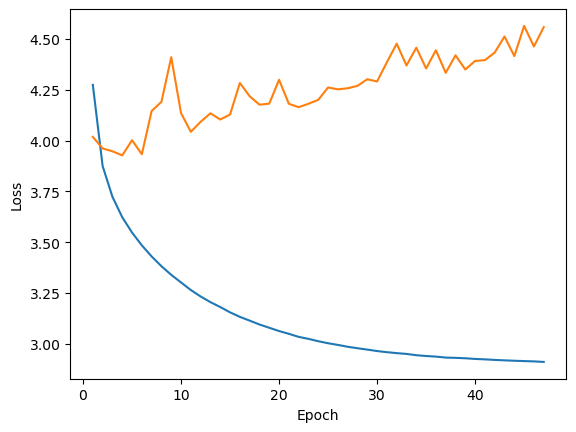

47 epochs : train_loss = 2.91148798754939, validation loss = 4.55781646872283


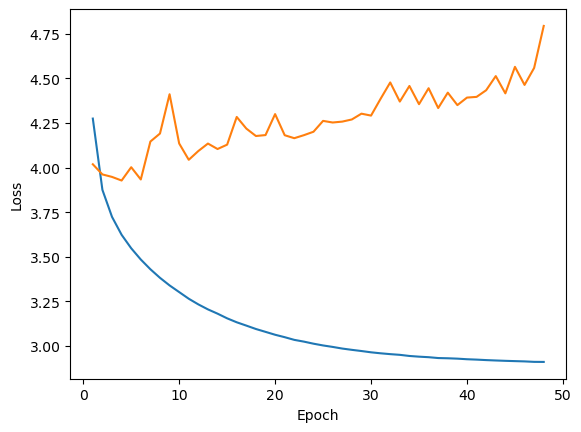

48 epochs : train_loss = 2.911134704608741, validation loss = 4.793016368227455


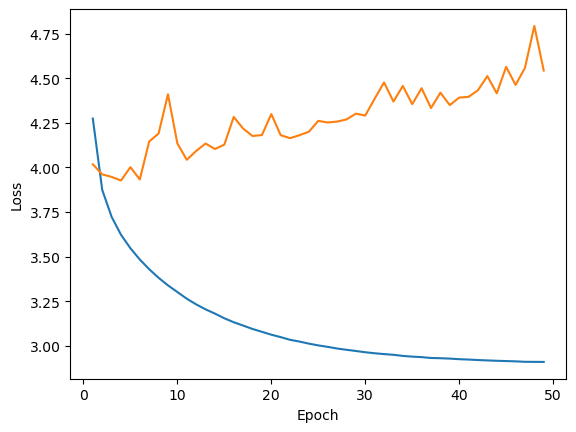

49 epochs : train_loss = 2.910840486701582, validation loss = 4.542845568495759


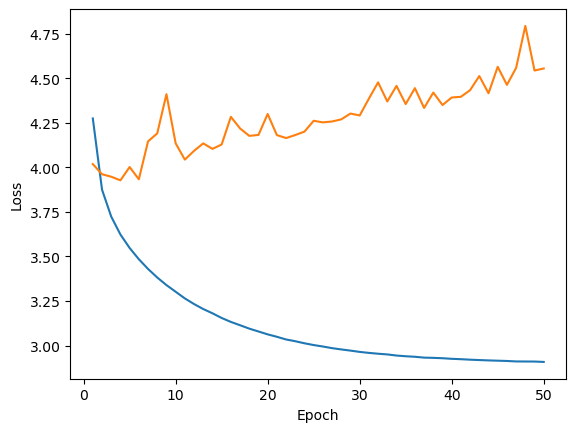

50 epochs : train_loss = 2.908758231150363, validation loss = 4.554346865722549


In [38]:
train_loss = []
val_loss = []
lowest_val = 100
for epoch in range(1, epochs+1):
    model.train()
    train_loss.append(0)
    val_loss.append(0)
    for idx, (img, captions, img_ids) in enumerate(iter(train_loader)):
        
        # store the device (same-same)
        img, captions = img.to(device), captions.to(device)
        
        # make gradients zero
        optimizer.zero_grad()
        
        # pass through encoder-decoder model 
        pred_caps, attentions = model(img, captions)
        
        # calculate batch loss
        targets = captions[:, 1:]
        
        loss = criterion(pred_caps.view(-1, vocab_sz), targets.reshape(-1))
        train_loss[-1] += loss.item() * train_loader.batch_size
        
        # backward pass
        loss.backward()    # update the NN weights
        
        # update the weights in optimizer
        optimizer.step()
        
#         # if it is batch to print
#         if (idx + 1) % print_each == 0:
#             print("Epoch: {} loss: {:.5f}".format(epoch, loss.item()))
            
#             # generate the captions for a whole batch
#             model.eval()
#             with torch.no_grad():
#                 # dls or validation_loader
#                 itr = iter(validation_loader)
#                 img, _, _ = next(itr)
                
#                 # extract features
#                 features = model.encoder(img[0:1].to(device))
                
#                 # get predictions
#                 pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
                
#                 # make it printable
#                 caption = ' '.join(pred_caps)
#                 print(caption)
#                 show_image(img[0])
            
#             # tell now will train
#             model.train()
    
    model.eval()
    with torch.no_grad():
        for idx, (img, captions, img_ids) in enumerate(iter(val_loader)):
            img, captions = img.to(device), captions.to(device)
            pred_caps, attentions = model(img, captions)
            targets = captions[:, 1:]
            loss = criterion(pred_caps.view(-1, vocab_sz), targets.reshape(-1))
            val_loss[-1] += loss.item() * val_loader.batch_size
    
    train_loss[-1] = train_loss[-1] / len(train_sampler)
    val_loss[-1] = val_loss[-1] / len(val_sampler)
    
    plt.clf()
    plt.plot(list(range(1, epoch+1)), train_loss, label='train')
    plt.plot(list(range(1, epoch+1)), val_loss, label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    print(str(epoch) + " epochs : train_loss = " + str(train_loss[-1]) + ", validation loss = " + str(val_loss[-1]))
    
    # save latest model
    if lowest_val > val_loss[-1]:
        PATH = './weights/IQA_' + str(epoch) + '.pt'
        torch.save(model.state_dict(), PATH)
        lowest_val = val_loss[-1]

In [39]:
PATH = './weights/IQA_50.pt'
torch.save(model.state_dict(), PATH)

## Model Testing

### Make Prediction

In [49]:
PATH = './weights/IQA_4.pt'

In [50]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Original: <start> awesome capture , great clarity and detail , . <end>
torch.Size([1, 3, 299, 299])
Predicted: <start> nice use of color and light . <end>


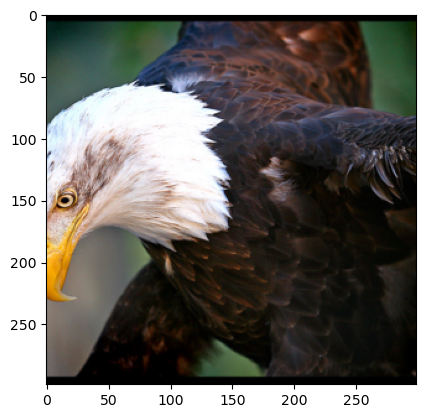

In [61]:
# # generate the captions for a whole batch
model.eval()
with torch.no_grad():
    # dls or validation_loader
    itr = iter(test_loader)
    img, captions, img_ids = next(itr)
    
    caption = captions[0:1][0].tolist()
    s = [dataset.vocab.itos[idx] for idx in caption if idx != 0] # if idx != 0 and idx != 1 and idx != 2
    print("Original:", ' '.join(s))
    
    # extract features
    print(img[0:1].shape)
    features = model.encoder(img[0:1].to(device))

    # get predictions
    pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

    # make it printable
    caption = ' '.join(pred_caps)
    print("Predicted:", caption)
    show_image(img[0])

In [62]:
def evaluateModel(mode, dls):
    model.eval()
    
    # to store references and predictions
    y, yhat = list(), list()
    
    # iterate all batches
    for idxx, (img, captions, img_ids) in enumerate(iter(dls)):
        print(idxx)
        with torch.no_grad():
            
            # iterate each record in batch
            for i in range(batch_size):
                
                # if empty record
                if len(captions[i:i+1]) == 0:
                    break
                
                # caption = captions[0:1][0].tolist()
                caption = captions[i:i+1][0].tolist()
                s = [dataset.vocab.itos[idx] for idx in caption if idx != 0] #  and idx != 1 and idx != 2
                
                y.append(descriptors[img_ids[i]])

                # extract features
                features = model.encoder(img[i:i+1].to(device))

                # get predictions
                pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

                yhat.append(pred_caps)
                # make it printable
                caption = ' '.join(pred_caps)
#                 print("Predicted ", caption)
#                 show_image(img[i])

#     y = [y]
#     print(y[0])
#     print(yhat[0])
    
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(y, yhat, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(y, yhat, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(y, yhat, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(y, yhat, weights=(0.25, 0.25, 0.25, 0.25)))

In [63]:
evaluateModel(model, test_loader)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27